## Part 1.2  Unsupervised Unlabelled Product Category Text Classification with TDIF Vectorizing and Kmeans ##



This model is applied due that category labels (**i.e. tablets, headphones**) are not in the dataset as a result product description variable is taken in order to transform it to a solid group category


- TIFD Vectorizer and Kmeans Clustering
- Optimal number of clusterings testing by Elbow and Silouhette Coefficient Score
- Kmeans fit and transform
- Result visualization 
           
           
 **kmeans_labels: Cluster labels by product description (added in Part 1.1)**

In [1]:
#All model library
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from wordcloud import WordCloud

#import warnings; warnings.filterwarnings(action='once')
from IPython.display import display, HTML, Image

In [2]:
pricing_data = 'DatafinitiElectronicsProductsPricingData.csv'
df = pd.read_csv (pricing_data)
pd.options.display.width = 0
print("Dataframe Dimensions:",df.shape)
pd.set_option('display.max_columns', 500)

#Drop columns that are not going to be used for the project
df = df[df.columns.drop(['sourceURLs','prices.availability','asins','manufacturerNumber','upc', 'primaryCategories','keys','id','ean'])]
#Drop columns that started with Unnamed
df = df[df.columns.drop(list(df.filter(regex='Unnamed*')))]

#Change name of columns
columns_to_change = {}
for column in df.columns:
    if column.startswith("prices."):
        columns_to_change[column] = column[7:]
df.rename(columns=columns_to_change, inplace=True)
df.rename(columns = {'amountMax':'price', 'amountMin':'disc_price','categories':'p_description'}, inplace = True) 

Dataframe Dimensions: (14592, 31)


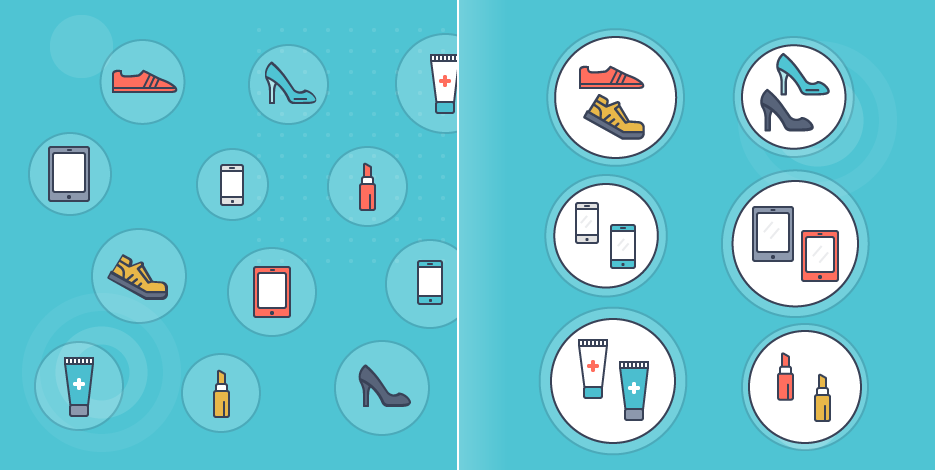

In [3]:
im1 = Image(filename = 'clustering_words.png', width = 800, height = 100)
display(im1)


### 1.2.1- Why an unsupervised texting model?


In our dataset we do not count with the category label or any label related to a solid group that would allow us to apply a supervised learning model. For this main reason, an unsupervised model **(Kmeans clustering)** is executed for text classification 


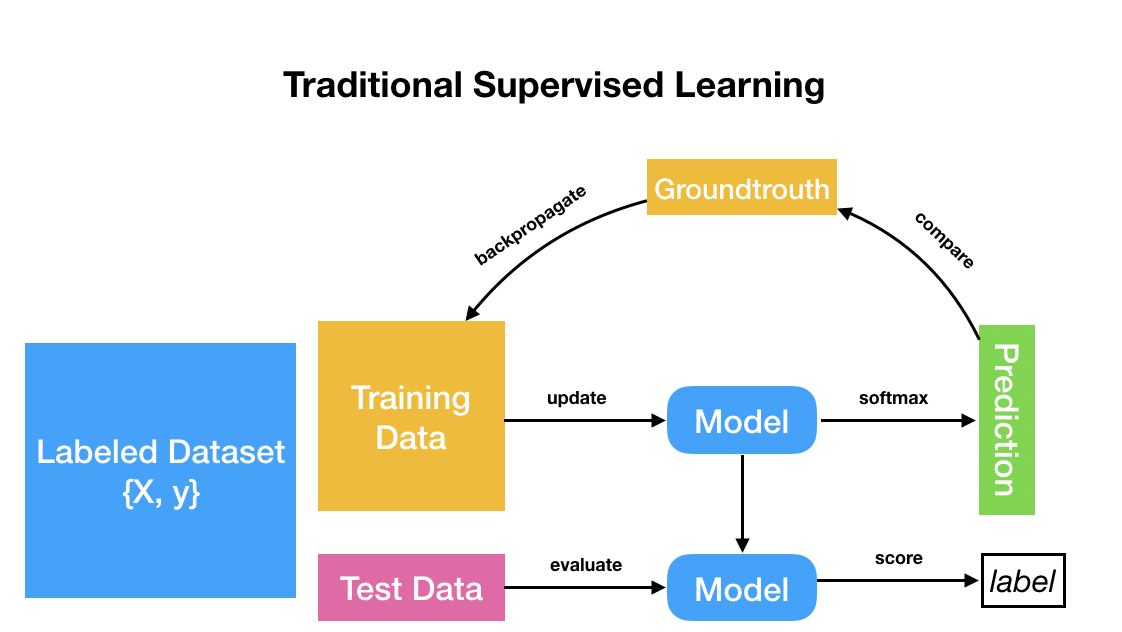

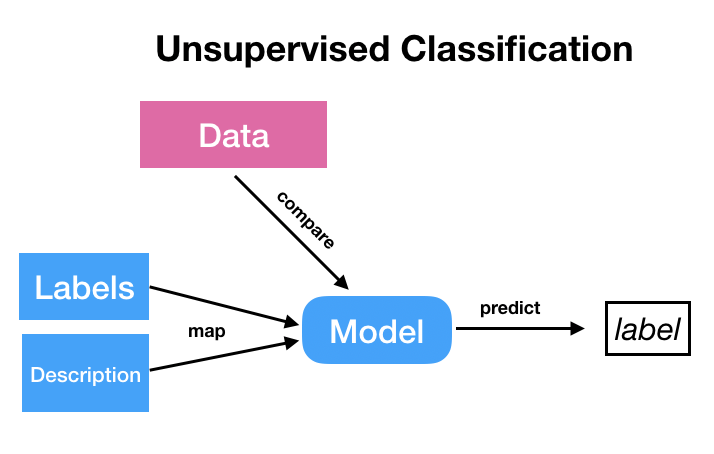

In [4]:
im2 = Image(filename= 'Git1.png', width=400, height=400)
im3 = Image(filename= 'Git2.png' ,width=400, height=400)
display(im2,im3)

Following we selected only the unique name and product description variables in order to reduce the computational effort to extract the information from a text and introduced to the kmeaans model

In [5]:
df_clust = df[['name','p_description']].drop_duplicates()

In [6]:
print ('-' * 10 + " DataFrame used for Unsupervised Texting Clustering for Product Labelling (p_description) " + '-' * 10 )
display(df_clust.head(10))

---------- DataFrame used for Unsupervised Texting Clustering for Product Labelling (p_description) ----------


,name,p_description
0,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,"Audio & Video Accessories,TV Mounts,TV Accesso..."
1,Boytone - 2500W 2.1-Ch. Home Theater System - ...,"Stereos,Portable Bluetooth Speakers,TV, Video ..."
13,DENAQ - AC Adapter for TOSHIBA SATELLITE 1700 ...,"Computers,Office,Computer Accessories,Computer..."
18,DreamWave - Tremor Portable Bluetooth Speaker ...,"Portable Bluetooth Speakers,Bluetooth & Wirele..."
23,NS-SP1800BL 5.1-Channel Home Theater System (B...,"Surround Speakers,Electronics Features,Surroun..."
28,Universal Remote Control - 48-Device Universal...,"Audio & Video Accessories,Remote Controls,Elec..."
33,Acoustimass 6 Series V Home Theater Speaker Sy...,"Surround Speakers,TV, Video & Home Audio,Surro..."
38,Samsung - 850 PRO 512GB Internal SATA III Soli...,"Internal Solid State Drives,Solid State Drives..."
40,Corsair Vengeance LPX 16GB (2x8GB) DDR4 DRAM 3...,"Computers,Memory (RAM),Computers & Accessories..."
49,Outdoor Tech Buckshot Pro Bluetooth Speaker,"Bluetooth & Wireless Speakers,Portable Audio &..."


In [7]:
print("Unsupervised Texting Clustering for Product Labelling Dataframe Dimensions:",df_clust.shape)
print("Null Values Check:" , df_clust.isnull().sum())

Unsupervised Texting Clustering for Product Labelling Dataframe Dimensions: (1245, 2)
Null Values Check: name             0
p_description    0
dtype: int64


### Text preprocessing phase 

**Text Normalization** Stopwords removal, punctuation 

**Lemmatization** is similar to stemming but it brings context to the words. So it links words with similar meaning to  one word.Lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

Source:https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
    
**Tokenization**



In [8]:
lemmatizer = WordNetLemmatizer() 

#Text Tokenization and normalization 

new_words = []

for corpus in df_clust['p_description']:
    corpus = re.sub(r'[^\w\s]', ' ', corpus)
    corpus= corpus.replace("&", "")
    new_words.append(corpus.lower())

In [9]:
#Tokenize words with word_tokenize from nltk
df_clust['clust1'] = new_words  

#tokens = new_words.map(word_tokenize).values
df_clust['clust1'] = df_clust['clust1'].map(word_tokenize).values

In [10]:
#Here we dont delete the duplicates in each row or product description in order to analyze the TFID and see the score of the kmeans clustering 

lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

lemonly_words = []
for clust2 in df_clust['clust1']:
    #clust2= list(set(clust2))
    lemmatized_word =[]
    for word in clust2:
        if word not in stop_words:
            lemmatized_word.append(lemmatizer.lemmatize(word))
    lemonly_words.append(list(lemmatized_word))
df_clust['clust_lemmt'] = lemonly_words

### WordCloud with Lemmatized Word Frequency Distribution

Wordcload help the reader to understand the words with more frequency in our entire product_description feature

(-0.5, 2999.5, 1999.5, -0.5)

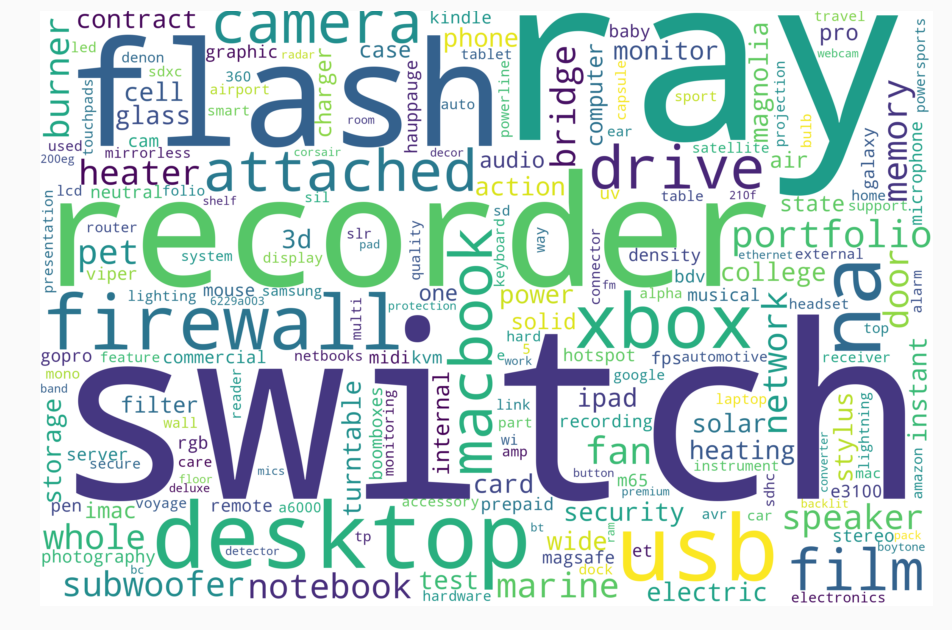

In [11]:
bg_color = (0.98,0.98,0.98)

wordcloud_col = []
#Wordcloud preprocessing data
for individual_words in df_clust['clust_lemmt']:
     wordcloud_col.append(" ".join(individual_words))
df_clust['process'] = wordcloud_col

#Word cloud dataframe
cluster_count = df_clust.groupby('name')['process'].apply(lambda x: nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(x))))
cluster_count = pd.DataFrame(cluster_count).reset_index()
cluster_count = cluster_count.rename(columns = {'level_1': 'Word', 'word_cloud': 'Count'})
word_cloud = cluster_count.groupby('Word')['process'].sum().reset_index()

#Dictionary with word frequency for wordcloud
word_dict = dict(zip(cluster_count.Word, cluster_count.process))

#Wordcloudplot 
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white').generate_from_frequencies(word_dict)
fig = plt.figure(figsize=(16,13),
     facecolor = bg_color,
     edgecolor = bg_color)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

### TF-IDF Vectorizer  

In order to perform machine learning on text, we need to transform our documents into vector representations such that we can apply numeric machine learning. This process is called feature extraction or more simply, vectorization, and is an essential first step toward language-aware analysis.

- To achieve that, Tf-idf Vectorizer or frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word or n-gram is to a document in a collection or corpus.

In [12]:
#TFID Vectorizer from preprocessed text
vect = TfidfVectorizer(preprocessor=' '.join, stop_words = 'english', lowercase = False)  
matrix = vect.fit_transform(lemonly_words)

### Optimal Clusters for Kmeans Modeling  

    (Elbow and Silohuette Average Score)


**Elbow Method**
Using the Elbow Method, the algorithm estimates the center of each cluster, then measures the average distance each point in the cluster is from the center. Taking the average of these distances gives us the Within-Cluster-Sum of Squared Errors (WCSS). We can plot the WCSS as the number of clusters increases, looking for the point where the WCSS levels off.

**Silhouette Coefficient**
The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.

Source:https://scikit-learn.org/


By calculating Euclidean distance a(or cosine similarity) between two word vectors provides an effective method for measuring the linguistic or semantic similarity of the corresponding words


Silohuette Results explanation

Best 1 and worst -1

- If it is 0   Indicate overlapping clusters
- If it is 1   The sample is far away from the neighboring clusters.
- If it is -1  Generally indicate that a sample has been assigned to the wrong cluster

Following, optimal number of clusters were extracted with Elbow and Silohuette average score. 
Optimal clusters fed the kmeans model 

Optimal number of clusters: 43 with silohuette average of: 0.2909096207201245
Elbow Score: 433.05390519289404


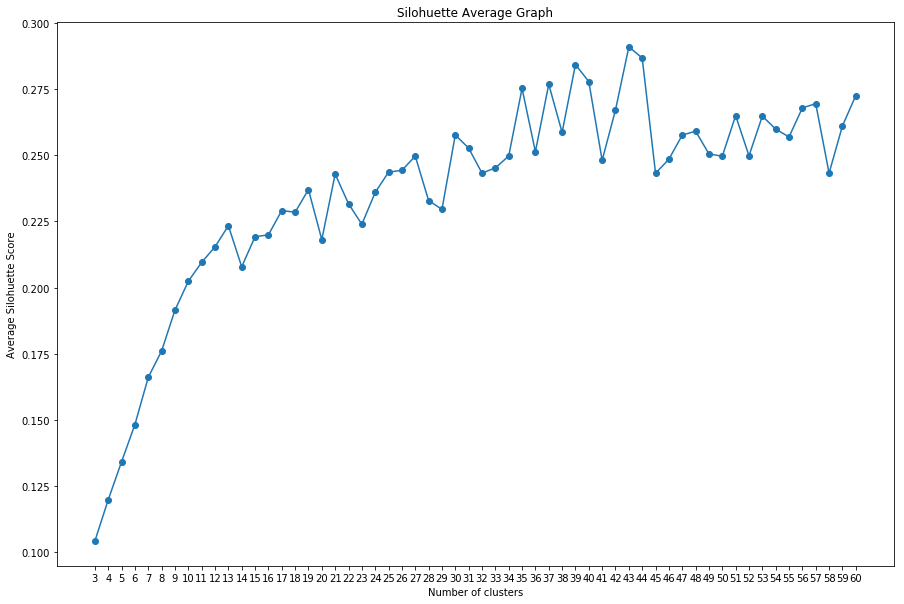

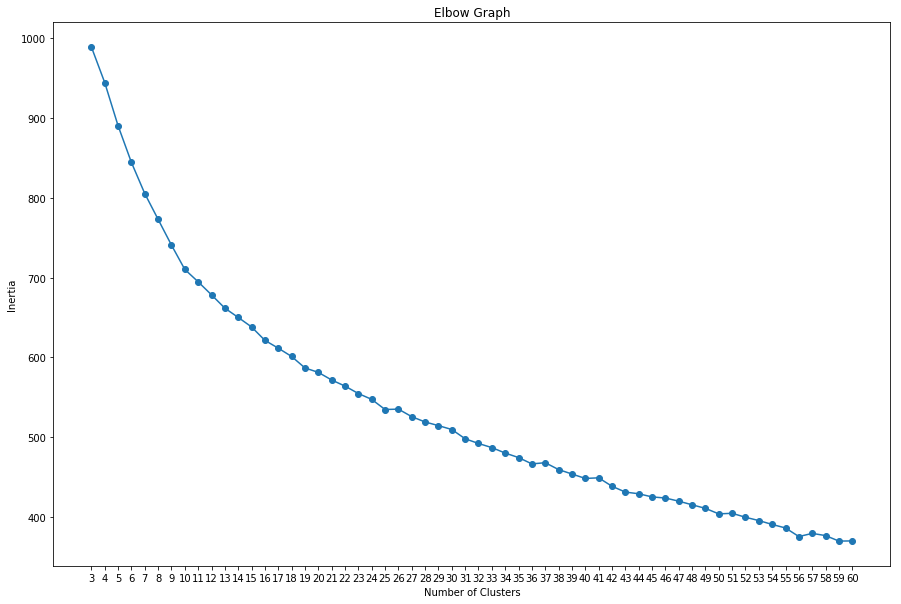

In [13]:
sil = []
inertias=[]
kmax = 60
Range_= range(3, kmax+1)
#Finding the best silohuette average score 
for k in Range_:
    kmeans = KMeans(init='k-means++',n_clusters = k,n_init=15).fit(matrix)
    labels = kmeans.labels_
    sil.append(silhouette_score(matrix, labels, metric = 'euclidean'))
    
     # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
maxpos = sil.index(max(sil))
#Optimal number of clusters
n_clusters_opt = maxpos + 3


# Kmeans model fit and predict
model = KMeans(n_clusters=n_clusters_opt)
model.fit(matrix)
model_clust = model.predict(matrix)
df_clust['labels_kmeans'] = model_clust

inertia_score= model.inertia_

print("Optimal number of clusters:",n_clusters_opt, "with silohuette average of:",(max(sil)))
print("Elbow Score:",inertia_score )
    

    
plt.rcParams['figure.figsize'] = [15, 10]
    
#Silohuette Average Score plot
plt.plot(Range_, sil, '-o')
plt.title('Silohuette Average Graph')
plt.xlabel('Number of clusters');
plt.ylabel('Average Silohuette Score')
plt.xticks(Range_)
plt.show()
    
# Elbow Score Plot
plt.plot(Range_, inertias, '-o')
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters');
plt.ylabel('Inertia')
plt.xticks(Range_)
plt.show()

### Measure feature weight per each cluster and pick up to 80% cummulative weight importance  by each TDIF Vectorized cluster 

In order to achieved solid labelling based from our results. We would take the words from each cluster that has a cummulative importance weight percentage of at least 80%

In [14]:
from sklearn.preprocessing import normalize
tf_idf_norm = normalize(matrix)
tf_idf_array = tf_idf_norm.toarray()

In [15]:
#Function to get the top features per cluster in TDIF
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    top_features = []
    for label in labels:
        id_temp = np.where(prediction == label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top n_feats scores
        features = vect.get_feature_names()
        best_features = [(label, features[i], x_means[i]) for i in sorted_means]
        top_features.extend(best_features)
    return top_features

In [16]:
#Get 5 top features by TDIF Vectorized cluster weight
top_features_cluster = get_top_features_cluster(tf_idf_array, model_clust, 5)
#Convert to dataframe
df_weight_cluster = pd.DataFrame(top_features_cluster, columns = ['Cluster','Word','Weight'])
#Dataframe example
display(df_weight_cluster.head(5))

,Cluster,Word,Weight
0,0,receiver,0.542552
1,0,amplifier,0.450277
2,0,home,0.280984
3,0,audio,0.240397
4,0,theater,0.146989


In [17]:
#Add Cummulative sum and percentage to highlight weight importance in words per cluster 
df_weight_cluster['cum_sum'] = df_weight_cluster.groupby('Cluster')['Weight'].cumsum()

p_s = []
num_clusters = max(df_weight_cluster['Cluster'])
for i in range(num_clusters + 1):
    cluster_list = df_weight_cluster[df_weight_cluster.Cluster == i]
    for row in cluster_list:
        cum_sum = cluster_list['Weight'].cumsum()
        percentage_sum = 100 * (cum_sum / cluster_list['Weight'].sum())
        cluster_list['test'] = percentage_sum
    p_s.extend(cluster_list['test'])
df_weight_cluster["Percentage_Sum"] = p_s

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [18]:
 df_weight_cluster[:5]

,Cluster,Word,Weight,cum_sum,Percentage_Sum
0,0,receiver,0.542552,0.542552,32.660232
1,0,amplifier,0.450277,0.992828,59.765762
2,0,home,0.280984,1.273813,76.680311
3,0,audio,0.240397,1.514210,91.151621
4,0,theater,0.146989,1.661199,100.000000


In [19]:
#Grab all words per cluster that count with up to 80% in cummulative percentage 
df_weight_cluster = df_weight_cluster[df_weight_cluster['Percentage_Sum'] < 80]

### Vizualization results (80% percentage cummulative weight importance by each TDIF weight cluster)

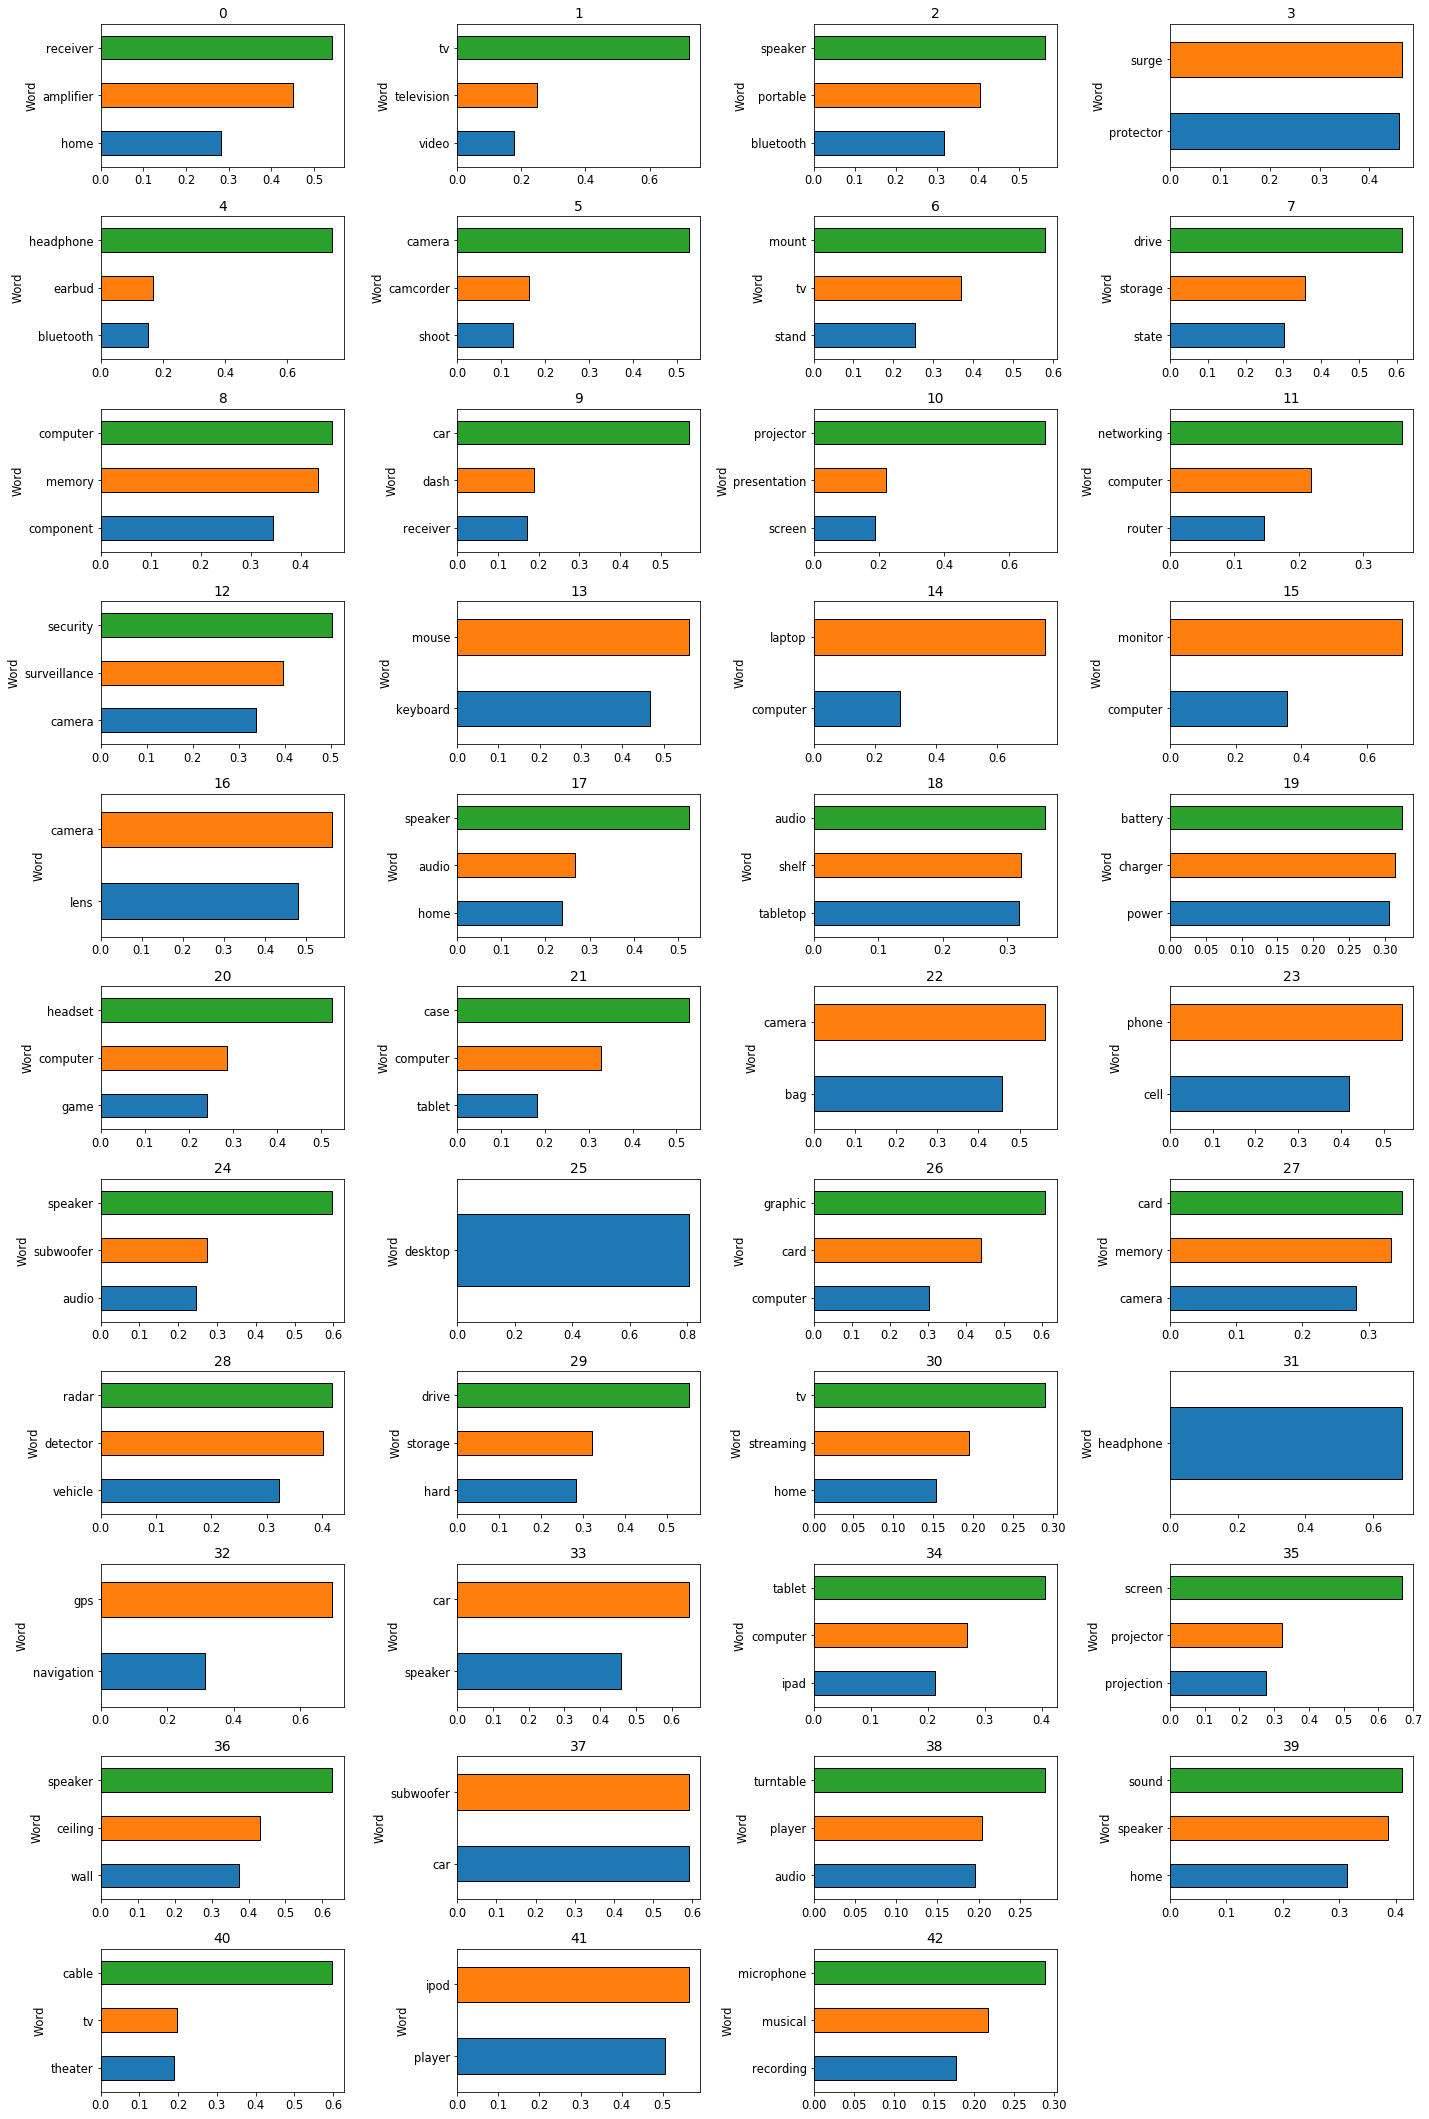

In [20]:
#plt.figure(figsize=(20,40), facecolor='white')
plt.figure(figsize=(20,40))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 11.5}
plt.rc('font', **font)

# plot numbering starts at 1, not 0
plot_number = 1
for cluster_name, selection in df_weight_cluster.groupby('Cluster'):
    ax = plt.subplot(15, 4, plot_number)
    selection.sort_values(by='Weight').plot.barh(x='Word', y='Weight', ax=ax, label=cluster_name, legend=False, edgecolor='k')
    ax.set_title(cluster_name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

### Integrate Revelant Words to a Solid category_name label

In [21]:
#Select cluster words for category that adds up to 80% weight in the overall percentage
df_weight_cluster['Category_name'] = df_weight_cluster.groupby('Cluster')['Word'].transform(lambda x: ', '.join(x))
df_category_name = df_weight_cluster[['Cluster','Category_name']].drop_duplicates()
df_category_name[:5]

,Cluster,Category_name
0,0,"receiver, amplifier, home"
5,1,"tv, television, video"
10,2,"speaker, portable, bluetooth"
15,3,"surge, protector"
20,4,"headphone, earbud, bluetooth"


In [22]:
#Merged cluster results to the original dataframe for exploratory analysis next step phase
df_category = pd.merge(df_category_name[['Cluster','Category_name']],df_clust[['name','p_description','labels_kmeans']],left_on = ['Cluster'],right_on = ['labels_kmeans'], how='inner')

In [23]:
#Adding category name into our main dataset
df_2 = pd.merge(df,df_category[['Cluster','Category_name','name','p_description']], on=['name','p_description'], how='inner')

In [26]:
df_2 = df_2[[ 'Cluster','Category_name','name','price','merchant','condition','isSale', 'brand', 'p_description', 'currency',
       'dateAdded', 'dateSeen', 'dateUpdated', 'imageURLs',
       'manufacturer', 
       'shipping', 'sourceURLs', 'weight']]

## New dataframe with category labelled for each product based on their product description

In [27]:
display(df_2.head(5))

,Cluster,Category_name,name,price,merchant,condition,isSale,brand,p_description,currency,dateAdded,dateSeen,dateUpdated,imageURLs,manufacturer,shipping,sourceURLs,weight
0,6,"mount, tv, stand",Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,104.99,Bestbuy.com,New,False,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",USD,2015-04-13T12:00:51Z,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",2018-05-12T18:59:48Z,https://images-na.ssl-images-amazon.com/images...,NaN,NaN,http://www.bestbuy.com/site/sanus-tv-wall-moun...,32.8 pounds
1,17,"speaker, audio, home",Boytone - 2500W 2.1-Ch. Home Theater System - ...,69.00,Walmart.com,New,True,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",USD,2015-05-18T14:14:56Z,2017-12-14T06:00:00Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Expedited,https://www.walmart.com/ip/BOYTONE-BT210FB-BLA...,14 pounds
2,17,"speaker, audio, home",Boytone - 2500W 2.1-Ch. Home Theater System - ...,69.00,Walmart.com,New,False,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",USD,2015-05-18T14:14:56Z,2017-09-08T05:00:00Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Expedited,https://www.walmart.com/ip/Boytone-BT-210F-Blu...,14 pounds
3,17,"speaker, audio, home",Boytone - 2500W 2.1-Ch. Home Theater System - ...,69.99,Bestbuy.com,New,False,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",USD,2015-05-18T14:14:56Z,2017-10-10T05:00:00Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,NaN,https://www.bestbuy.com/site/boytone-2500w-2-1...,14 pounds
4,17,"speaker, audio, home",Boytone - 2500W 2.1-Ch. Home Theater System - ...,66.99,Bestbuy.com,New,False,Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",USD,2015-05-18T14:14:56Z,2017-08-28T07:00:00Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,NaN,https://www.bestbuy.com/site/boytone-2500w-2-1...,14 pounds


In conclusion our Category_name and Cluster is defined in our dataset, as a result we would be able to analyze prices by a grouped category 